/home/nickr/gwenv/lib/python3.12/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/home/nickr/gwenv/lib/python3.12/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack

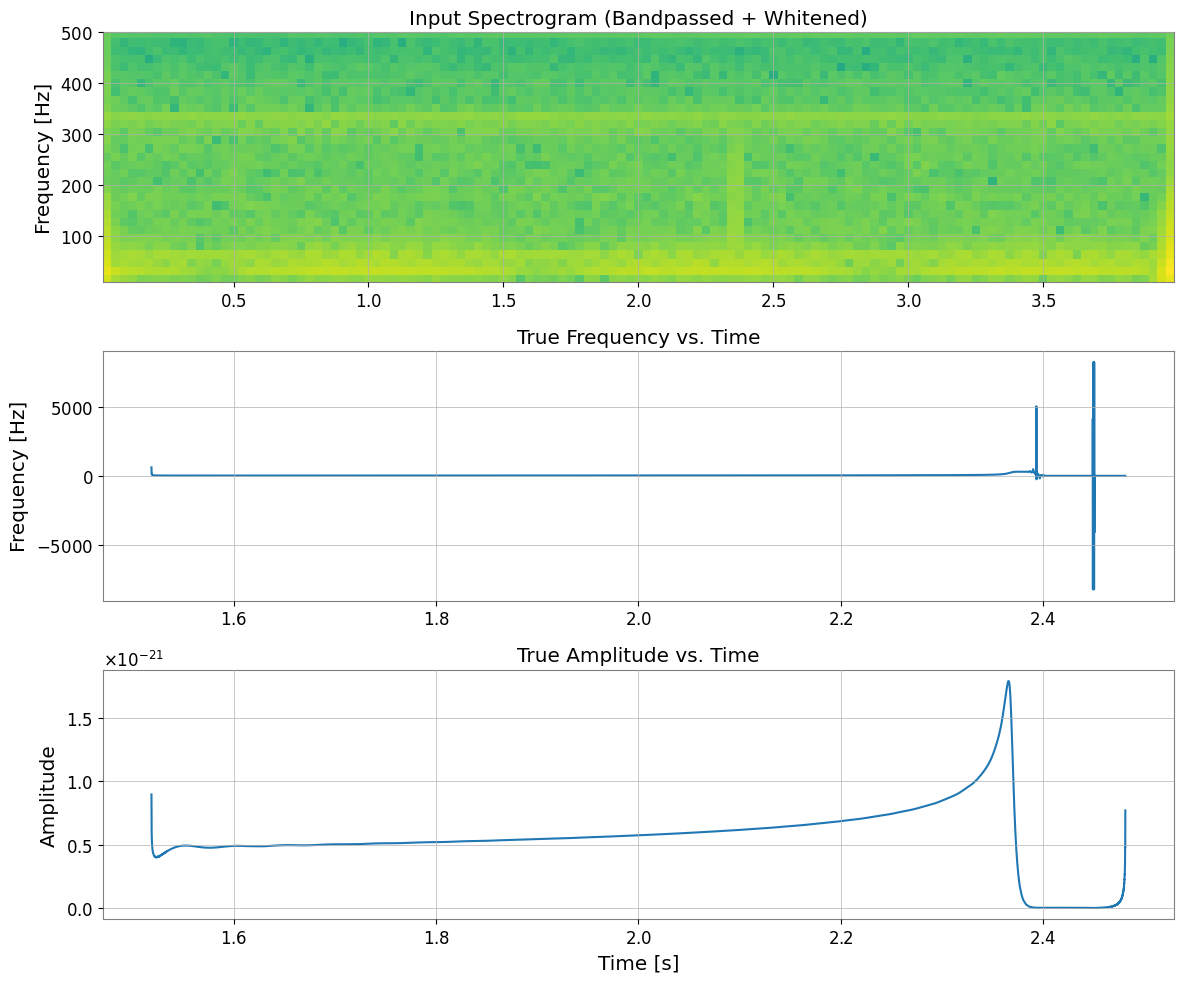

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from gwpy.timeseries import TimeSeries
from scipy.signal import spectrogram, butter, filtfilt, hilbert

# Parameters
sample_rate = 16384
duration = 4  # seconds
n_samples = duration * sample_rate
time = np.linspace(0, duration, n_samples)
gps = 1126259446  # quiet segment before GW150914

# Step 1: Fetch quiet real LIGO strain data
strain = TimeSeries.fetch_open_data('H1', gps, gps + duration)
strain = strain.resample(sample_rate)
ligo_noise = strain.value

# Step 2: Generate chirp
hp, _ = get_td_waveform(approximant='SEOBNRv4_opt',
                        mass1=30, mass2=30,
                        delta_t=1/sample_rate,
                        f_lower=20,
                        distance=400)
chirp = hp.numpy()

# Step 3: Inject chirp into middle of noise
chirp_padded = np.zeros_like(ligo_noise)
start_idx = len(ligo_noise) // 2 - len(chirp) // 2
chirp_padded[start_idx:start_idx + len(chirp)] = chirp
injected = ligo_noise + chirp_padded

# Step 4: Bandpass (30–350 Hz)
def bandpass(data, fs, low, high, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, data)

filtered = bandpass(injected, sample_rate, 30, 350)

# Step 5: Whitening
def whiten(data):
    return (data - np.mean(data)) / np.std(data)

whitened = whiten(filtered)

# Step 6: Spectrogram
f, t_spec, Sxx = spectrogram(whitened, fs=sample_rate, nperseg=1024, noverlap=512)

# Step 7: Labels from clean chirp
analytic_signal = hilbert(chirp)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.gradient(instantaneous_phase) * sample_rate / (2 * np.pi)

chirp_time = np.linspace(0, len(chirp)/sample_rate, len(chirp))
injected_time = chirp_time + start_idx / sample_rate

# Step 8: Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

axs[0].pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='auto')
axs[0].set_title("Input Spectrogram (Bandpassed + Whitened)")
axs[0].set_ylabel("Frequency [Hz]")
axs[0].set_ylim(10, 500)

axs[1].plot(injected_time, instantaneous_frequency)
axs[1].set_title("True Frequency vs. Time")
axs[1].set_ylabel("Frequency [Hz]")

axs[2].plot(injected_time, amplitude_envelope)
axs[2].set_title("True Amplitude vs. Time")
axs[2].set_ylabel("Amplitude")
axs[2].set_xlabel("Time [s]")

plt.tight_layout()
plt.show()
